# Upload Data


## Imports and Auxiliary Function

<p>The following are the libraries we are going to use for this lab:</p>

In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

In [2]:
import os
import tensorflow as tf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras import optimizers, regularizers

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization,  GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings("ignore")

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
def plot_loss(history):
  plt.figure(figsize=(20, 10))
  sns.set_style('whitegrid')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Wildfire Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

In [6]:
def plot_acc(history):
  plt.figure(figsize=(20, 10))
  sns.set_style('whitegrid')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Wildfire Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

In [7]:
def compute_class_freqs(labels):
    
  # total number of patients (rows)
  N = np.shape(labels)[0]
  
  positive_frequencies = np.sum(labels, axis = 0) / N
  negative_frequencies = 1 - positive_frequencies

  return positive_frequencies, negative_frequencies

# Dataset Preparation

In [8]:
train_path = "./data/train"
valid_path = "./data/valid"
test_path = "./data/test"

In [21]:
im_size = 224 #@param {type:"slider", min:64, max:350, step:1}
image_resize = (im_size, im_size, 3) 
batch_size_training = 100 #@param {type:"number"}
batch_size_validation = 100 #@param {type:"number"}
batch_size_test = 100 #@param {type:"number"}
num_classes = 2 #@param {type:"number"}

In [10]:
data_generator = ImageDataGenerator(dtype='float32', rescale= 1./255.)

In [11]:
train_generator = data_generator.flow_from_directory(train_path,
                                                   batch_size = batch_size_training,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

valid_generator = data_generator.flow_from_directory(valid_path,
                                                   batch_size = batch_size_validation,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [12]:
class_mapping = train_generator.class_indices
class_mapping

{'nowildfire': 0, 'wildfire': 1}

In [14]:
first_batch_train = train_generator.next()
first_batch_train

(array([[[[0.1254902 , 0.25882354, 0.12941177],
          [0.1254902 , 0.25882354, 0.12156864],
          [0.19607845, 0.32941177, 0.19215688],
          ...,
          [0.21176472, 0.2627451 , 0.16078432],
          [0.2392157 , 0.2901961 , 0.18823531],
          [0.20392159, 0.24313727, 0.14509805]],
 
         [[0.19215688, 0.33333334, 0.18431373],
          [0.05490196, 0.19607845, 0.04705883],
          [0.08627451, 0.23137257, 0.07058824],
          ...,
          [0.24313727, 0.29411766, 0.19215688],
          [0.23137257, 0.28235295, 0.18039216],
          [0.24313727, 0.28235295, 0.18431373]],
 
         [[0.10196079, 0.24705884, 0.07843138],
          [0.08627451, 0.23137257, 0.0627451 ],
          [0.13725491, 0.28235295, 0.1137255 ],
          ...,
          [0.23137257, 0.28235295, 0.18039216],
          [0.22352943, 0.27450982, 0.17254902],
          [0.22352943, 0.2627451 , 0.16470589]],
 
         ...,
 
         [[0.23529413, 0.30980393, 0.18431373],
          [0.27058

In [15]:
import PIL
print(PIL.__version__)
print(PIL.__file__)


10.4.0
g:\AProjects\FireCast\.venv\lib\site-packages\PIL\__init__.py


In [16]:
first_batch_valid = valid_generator.next()
first_batch_valid

(array([[[[0.5254902 , 0.5137255 , 0.38431376],
          [0.53333336, 0.5294118 , 0.40784317],
          [0.4039216 , 0.40784317, 0.28235295],
          ...,
          [0.1764706 , 0.21568629, 0.12156864],
          [0.14901961, 0.18823531, 0.09411766],
          [0.1764706 , 0.21568629, 0.12156864]],
 
         [[0.5568628 , 0.54509807, 0.42352945],
          [0.5372549 , 0.53333336, 0.4156863 ],
          [0.50980395, 0.5137255 , 0.3921569 ],
          ...,
          [0.26666668, 0.30588236, 0.21176472],
          [0.29411766, 0.33333334, 0.2392157 ],
          [0.3254902 , 0.3647059 , 0.27058825]],
 
         [[0.5254902 , 0.5137255 , 0.3921569 ],
          [0.54901963, 0.54509807, 0.427451  ],
          [0.49411768, 0.49803925, 0.37647063],
          ...,
          [0.29803923, 0.3372549 , 0.24313727],
          [0.33333334, 0.37254903, 0.2784314 ],
          [0.36862746, 0.40784317, 0.3137255 ]],
 
         ...,
 
         [[0.5647059 , 0.54901963, 0.43529415],
          [0.52549

In [17]:
labels = np.array(['nowildfire', 'wildfire'])

In [18]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

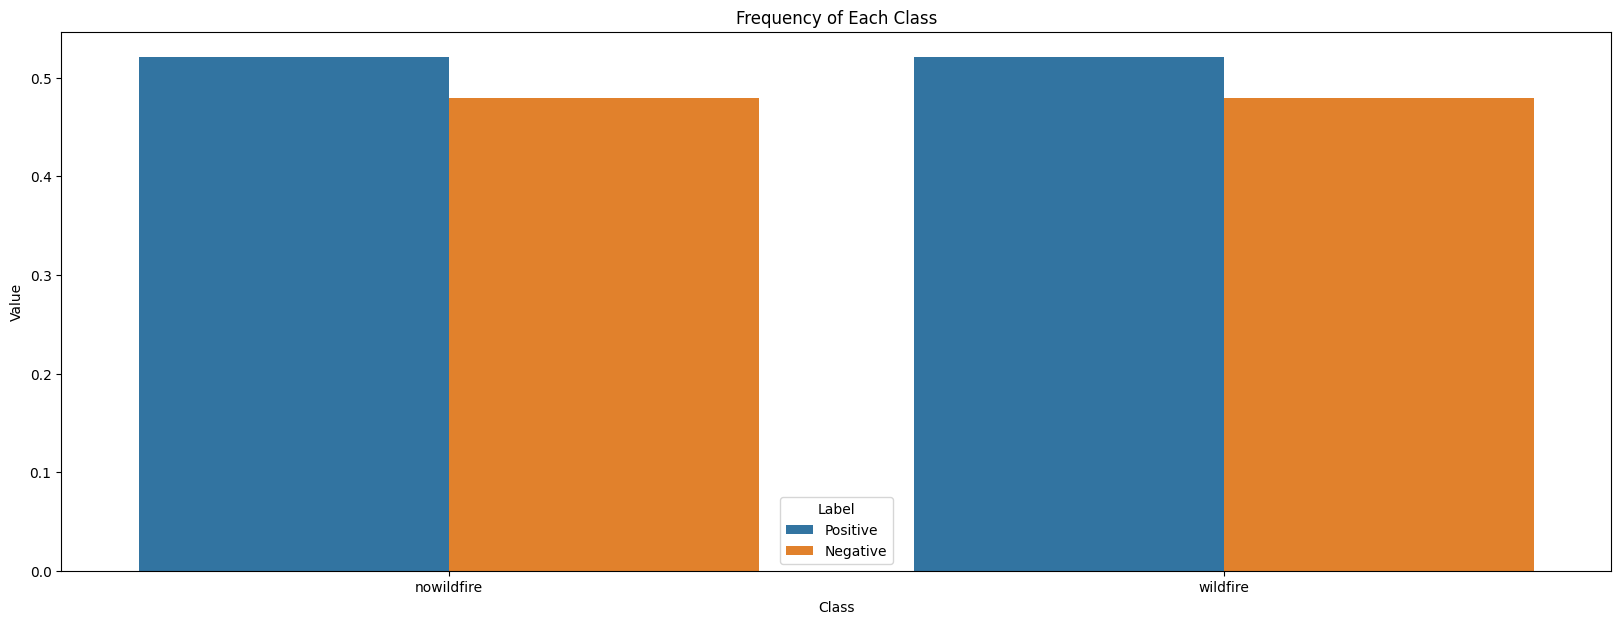

In [19]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

neg_rows = []
for i in range(2):
    neg_rows.append({"Class": labels[i], "Label": "Negative", "Value": freq_neg})

neg_df = pd.DataFrame(neg_rows)

# Concatenate dataframes using pd.concat (function)
data = pd.concat([data, neg_df], ignore_index=True)

plt.figure(figsize=(20, 7))
plt.title("Frequency of Each Class")
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)


# Compile and Fit Custom Model

In [20]:
def base_model(input_shape, repetitions): 
  
  input_ = tf.keras.layers.Input(shape=input_shape, name='input')
  x = input_
  
  for i in range(repetitions):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

  return x, input_

In [21]:
def final_model(input_shape, repetitions):
    
    x, input_ = base_model(input_shape, repetitions)

    x = Conv2D(64, 3, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    class_out = Dense(num_classes, activation='softmax', name='class_out')(x)

    model = Model(inputs=input_, outputs=class_out)

    print(model.summary())
    return model

In [22]:
model = final_model(image_resize, 4)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128   

In [ ]:

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plots/custom_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [25]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_model/custom_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [26]:
callbacks_list = [checkpoint, tensorboard_callback]

In [27]:
num_epochs = 10 #@param {type:"number"}
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(valid_generator)

In [28]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=valid_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
    callbacks=[callbacks_list],
)

Epoch 1/10
303/303 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.8958
Epoch 1: val_accuracy improved from -inf to 0.77127, saving model to saved_model\custom_best_model.h5
303/303 [==============================] - 912s 3s/step - loss: 0.2645 - accuracy: 0.8958 - val_loss: 0.4643 - val_accuracy: 0.7713
Epoch 2/10
303/303 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9274
Epoch 2: val_accuracy improved from 0.77127 to 0.93937, saving model to saved_model\custom_best_model.h5
303/303 [==============================] - 619s 2s/step - loss: 0.1893 - accuracy: 0.9274 - val_loss: 0.1675 - val_accuracy: 0.9394
Epoch 3/10
303/303 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9359
Epoch 3: val_accuracy improved from 0.93937 to 0.94540, saving model to saved_model\custom_best_model.h5
303/303 [==============================] - 623s 2s/step - loss: 0.1711 - accuracy: 0.9359 - val_loss: 0.1457 - val_accuracy: 0.9454
Epoc

# Analize the Model

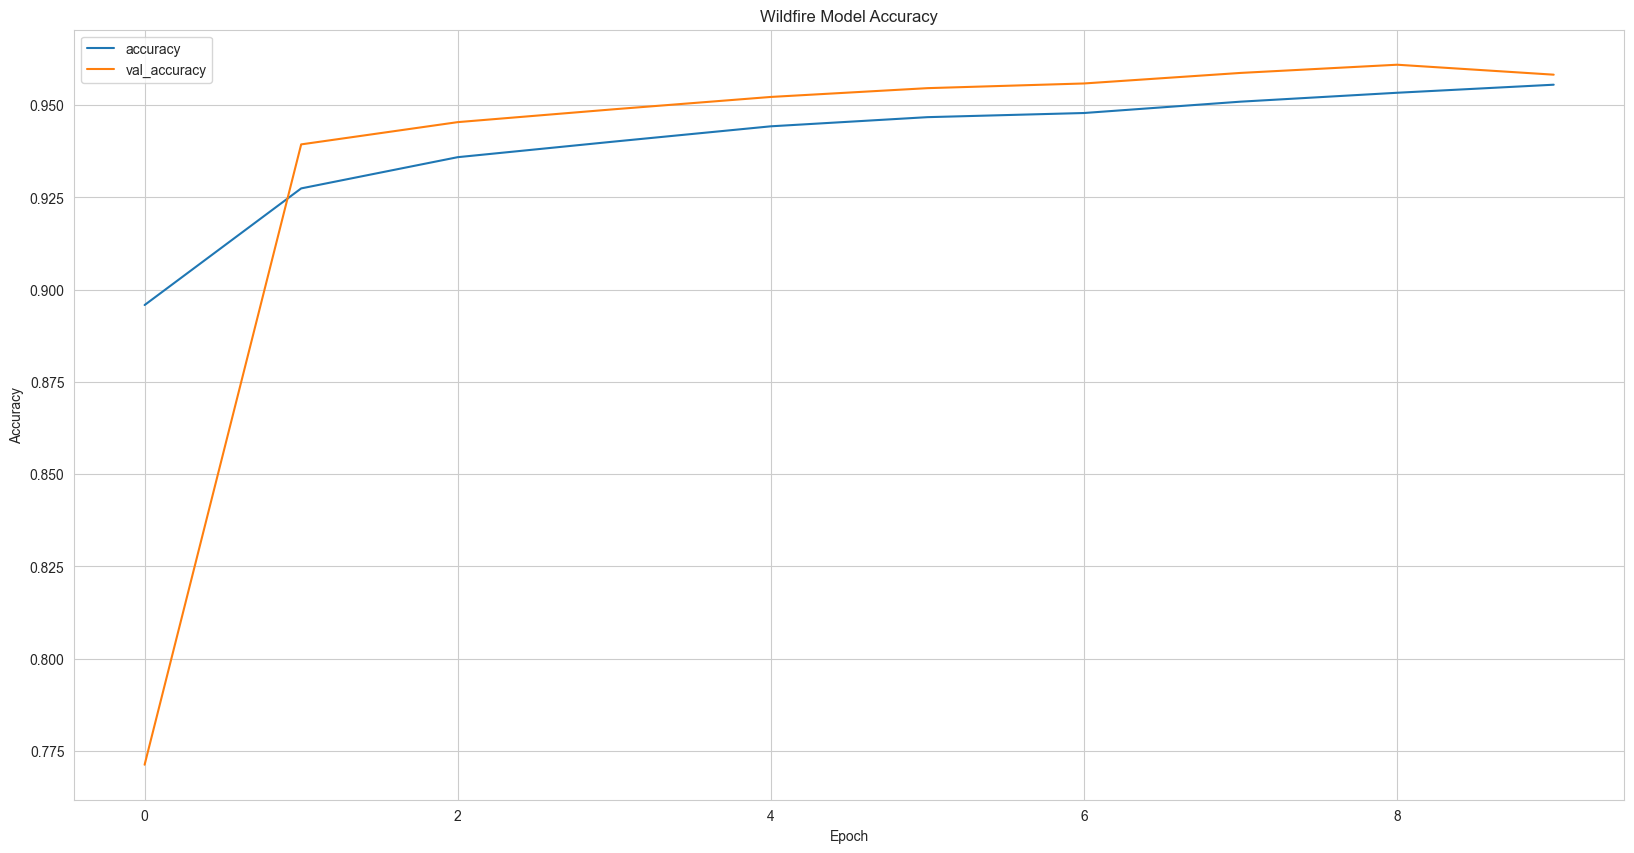

In [29]:
plot_acc(history)

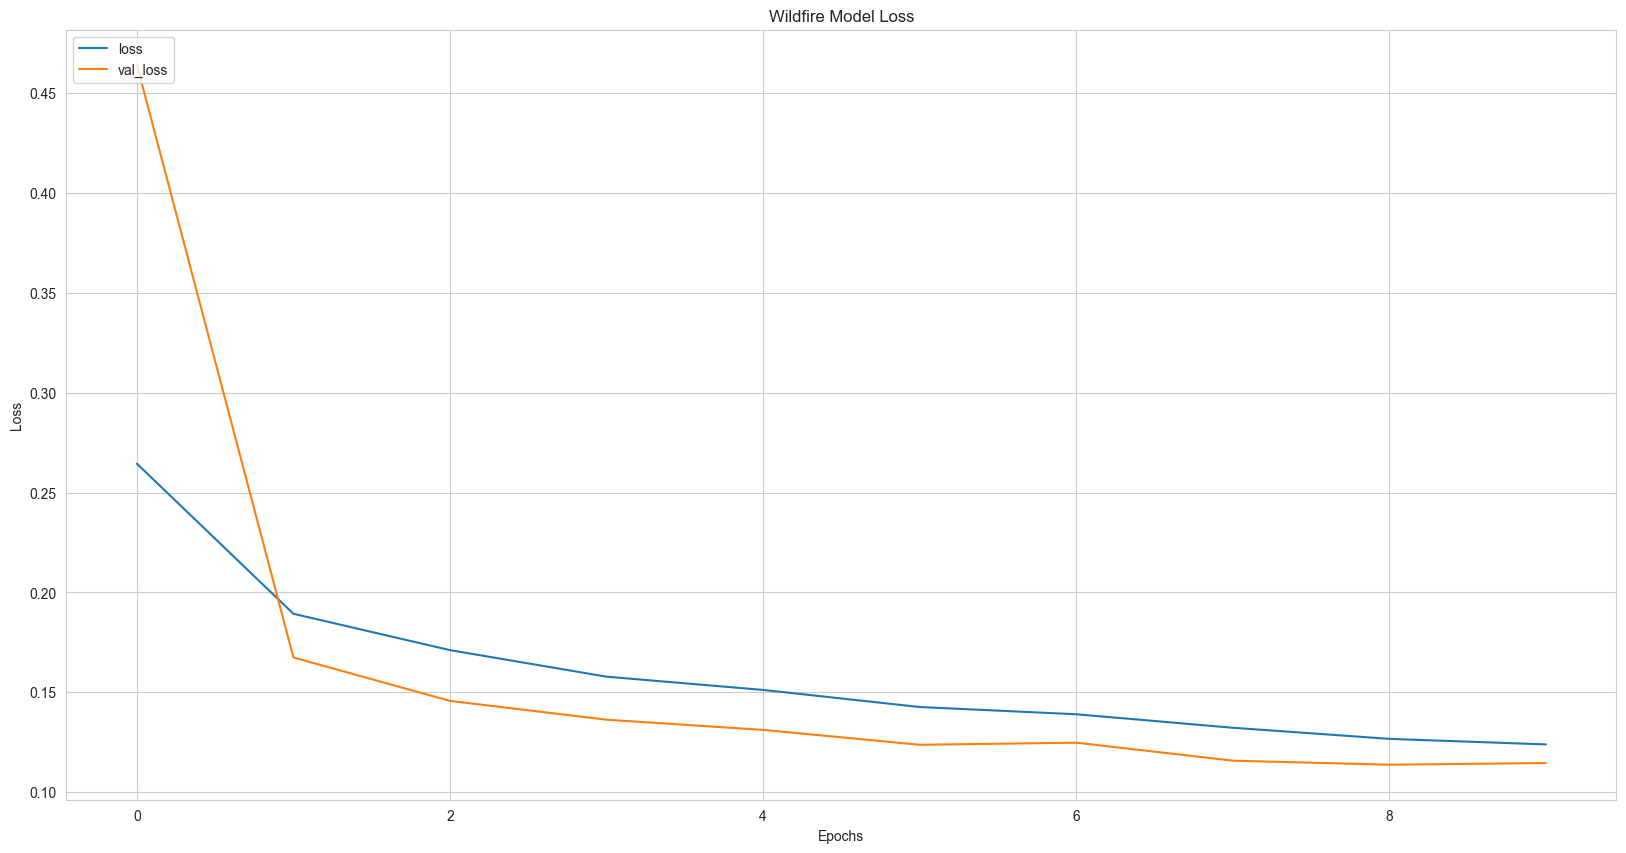

In [30]:
plot_loss(history)

In [31]:
model.save('CAM_model_10epoch.h5')
print("Model saved!")

Model saved!


# Make DataFrame for the Predictions

In [32]:
test_generator = data_generator.flow_from_directory(test_path,
                                                   batch_size = batch_size_test,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

Found 6300 images belonging to 2 classes.


In [33]:
filenames = test_generator.filenames

In [34]:
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1).round(3)

63/63 [==============================] - 67s 1s/step


In [35]:
filenames_df = pd.DataFrame(filenames, columns=['File Path'])
pred_df = pd.DataFrame(pred, columns=['No Wildfire Probability', 'Wildfire Probability'])
model_predictions = pd.concat([filenames_df, pred_df], axis=1)
model_predictions

,File Path,No Wildfire Probability,Wildfire Probability
0,"nowildfire\-113.91777,50.901087.jpg",0.001,0.999
1,"nowildfire\-113.91782,50.896917.jpg",0.842,0.158
2,"nowildfire\-113.91793,51.091205.jpg",0.993,0.007
3,"nowildfire\-113.918016,50.978447.jpg",0.026,0.974
4,"nowildfire\-113.918155,51.129969.jpg",0.999,0.001
...,...,...,...
6295,"wildfire\-79.48666,47.60672.jpg",0.024,0.976
6296,"wildfire\-79.489,49.16667.jpg",0.019,0.981
6297,"wildfire\-79.49726,48.89808.jpg",0.996,0.004
6298,"wildfire\-79.50932,48.06745.jpg",0.006,0.994


In [37]:
file_name='custom_model_predictions.csv'
model_predictions.to_csv(file_name, sep=',', encoding='utf-8')

# Building Class Activation Maps

In [5]:
model = load_model('CAM_model_10epoch.h5')

In [6]:
outputs = [layer.output for layer in model.layers[1:9]]

In [7]:
vis_model = Model(model.input, outputs)

In [8]:
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

In [9]:
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['conv2d', 'batch_normalization', 'max_pooling2d', 'conv2d_1', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_2', 'batch_normalization_2']


In [10]:
model.layers[-1]

In [11]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(64, 2)

In [12]:
cam_model  = Model(inputs=model.input, outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     128 

In [15]:
plot_model(cam_model, show_shapes=True, show_layer_names=True, to_file='model_plots/cam_model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
cam_model.save('cam_model_viz')
print("Model saved!")

INFO:tensorflow:Assets written to: cam_model_viz\assets


INFO:tensorflow:Assets written to: cam_model_viz\assets


Model saved!


In [16]:
def show_cam(image_value, features, results):

  features_for_img = features[0]
  prediction = results[0]

  class_activation_weights = gap_weights[:,0]
  class_activation_features = sp.ndimage.zoom(features_for_img, (im_size/10, im_size/10, 1), order=2)  
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  # Visualize the results
  plt.figure(figsize=(25, 25))
  plt.imshow(cam_output, cmap='jet', alpha=0.4)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.title('Class Activation Map')
  plt.figtext(.5, .05, f"No Wildfire Probability: {results[0][0] * 100}%\nWildfire Probability: {results[0][1] * 100}%", ha="center", fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":3})
  plt.colorbar()
  plt.show()

In [17]:
def convert_and_classify(image):
  import cv2
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, (im_size, im_size)) / 255.0
  tensor_image = np.expand_dims(img, axis=0)
  features, results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

In [18]:
img  = "./Screenshot 2025-06-12 144338.png"

In [19]:
gap_weights = (cam_model.layers[-1].get_weights()[0]) * -1
gap_weights.shape

(64, 2)

In [23]:
def compute_cam_and_probs(image_tensor, features, results, gap_weights, im_size):
    """
    Returns:
      cam_output: 2D array of the class activation map
      probs: 1D array of class probabilities (e.g. [no_wildfire, wildfire])
    """
    # extract the feature map for this image (H/10 × W/10 × channels)
    feat_map = features[0]
    # upsample to input size
    cam_features = sp.ndimage.zoom(
        feat_map,
        (im_size/feat_map.shape[0], im_size/feat_map.shape[1], 1),
        order=2
    )
    # dot with the GAP weights for class 1 (wildfire)
    cam_output = np.dot(cam_features, gap_weights[:, 1])
    # normalize to [0,1]
    cam_output = (cam_output - cam_output.min()) / (cam_output.max() - cam_output.min())
    
    # the model’s softmax output
    probs = results[0]
    return cam_output, probs

In [24]:
def convert_and_classify(image_path, cam_model, im_size=224):
    """
    Loads an image, runs it through cam_model, and returns:
      cam_output (2D array), probs ([no_wildfire, wildfire])
    """
    import cv2
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (im_size, im_size)) / 255.0
    tensor_image = np.expand_dims(img, axis=0)
    
    # get feature maps and predictions
    features, results = cam_model.predict(tensor_image)
    
    # grab the final dense layer weights (shape: channels × classes)
    gap_weights = cam_model.layers[-1].get_weights()[0]
    
    cam_output, probs = compute_cam_and_probs(
        tensor_image, features, results, gap_weights, im_size
    )
    return cam_output, probs

In [25]:
img_path = "./Screenshot 2025-06-12 144338.png"
cam_output, probs = convert_and_classify(img_path, cam_model, im_size=224)

# cam_output is a numpy array you can plt.imshow() or save to disk.
# probs is a length‑2 array: [no_wildfire_prob, wildfire_prob]
print(f"No Wildfire: {probs[0]*100:.1f}%, Wildfire: {probs[1]*100:.1f}%")

1/1 [==============================] - 0s 30ms/step
No Wildfire: 99.3%, Wildfire: 0.7%


In [26]:
cam_output

array([[0.6605507 , 0.66006875, 0.65862256, ..., 0.66227543, 0.666634  ,
        0.6680869 ],
       [0.6604879 , 0.6600043 , 0.65855366, ..., 0.6625522 , 0.6669193 ,
        0.668375  ],
       [0.66029924, 0.65981114, 0.6583469 , ..., 0.6633825 , 0.66777503,
        0.66923934],
       ...,
       [0.43959898, 0.43956742, 0.43947282, ..., 0.10210933, 0.1019996 ,
        0.10196299],
       [0.4397459 , 0.43971342, 0.439616  , ..., 0.1007007 , 0.10059971,
        0.10056598],
       [0.4397949 , 0.4397621 , 0.43966374, ..., 0.10023122, 0.10013299,
        0.1001003 ]], dtype=float32)

1/1 [==============================] - 0s 258ms/step


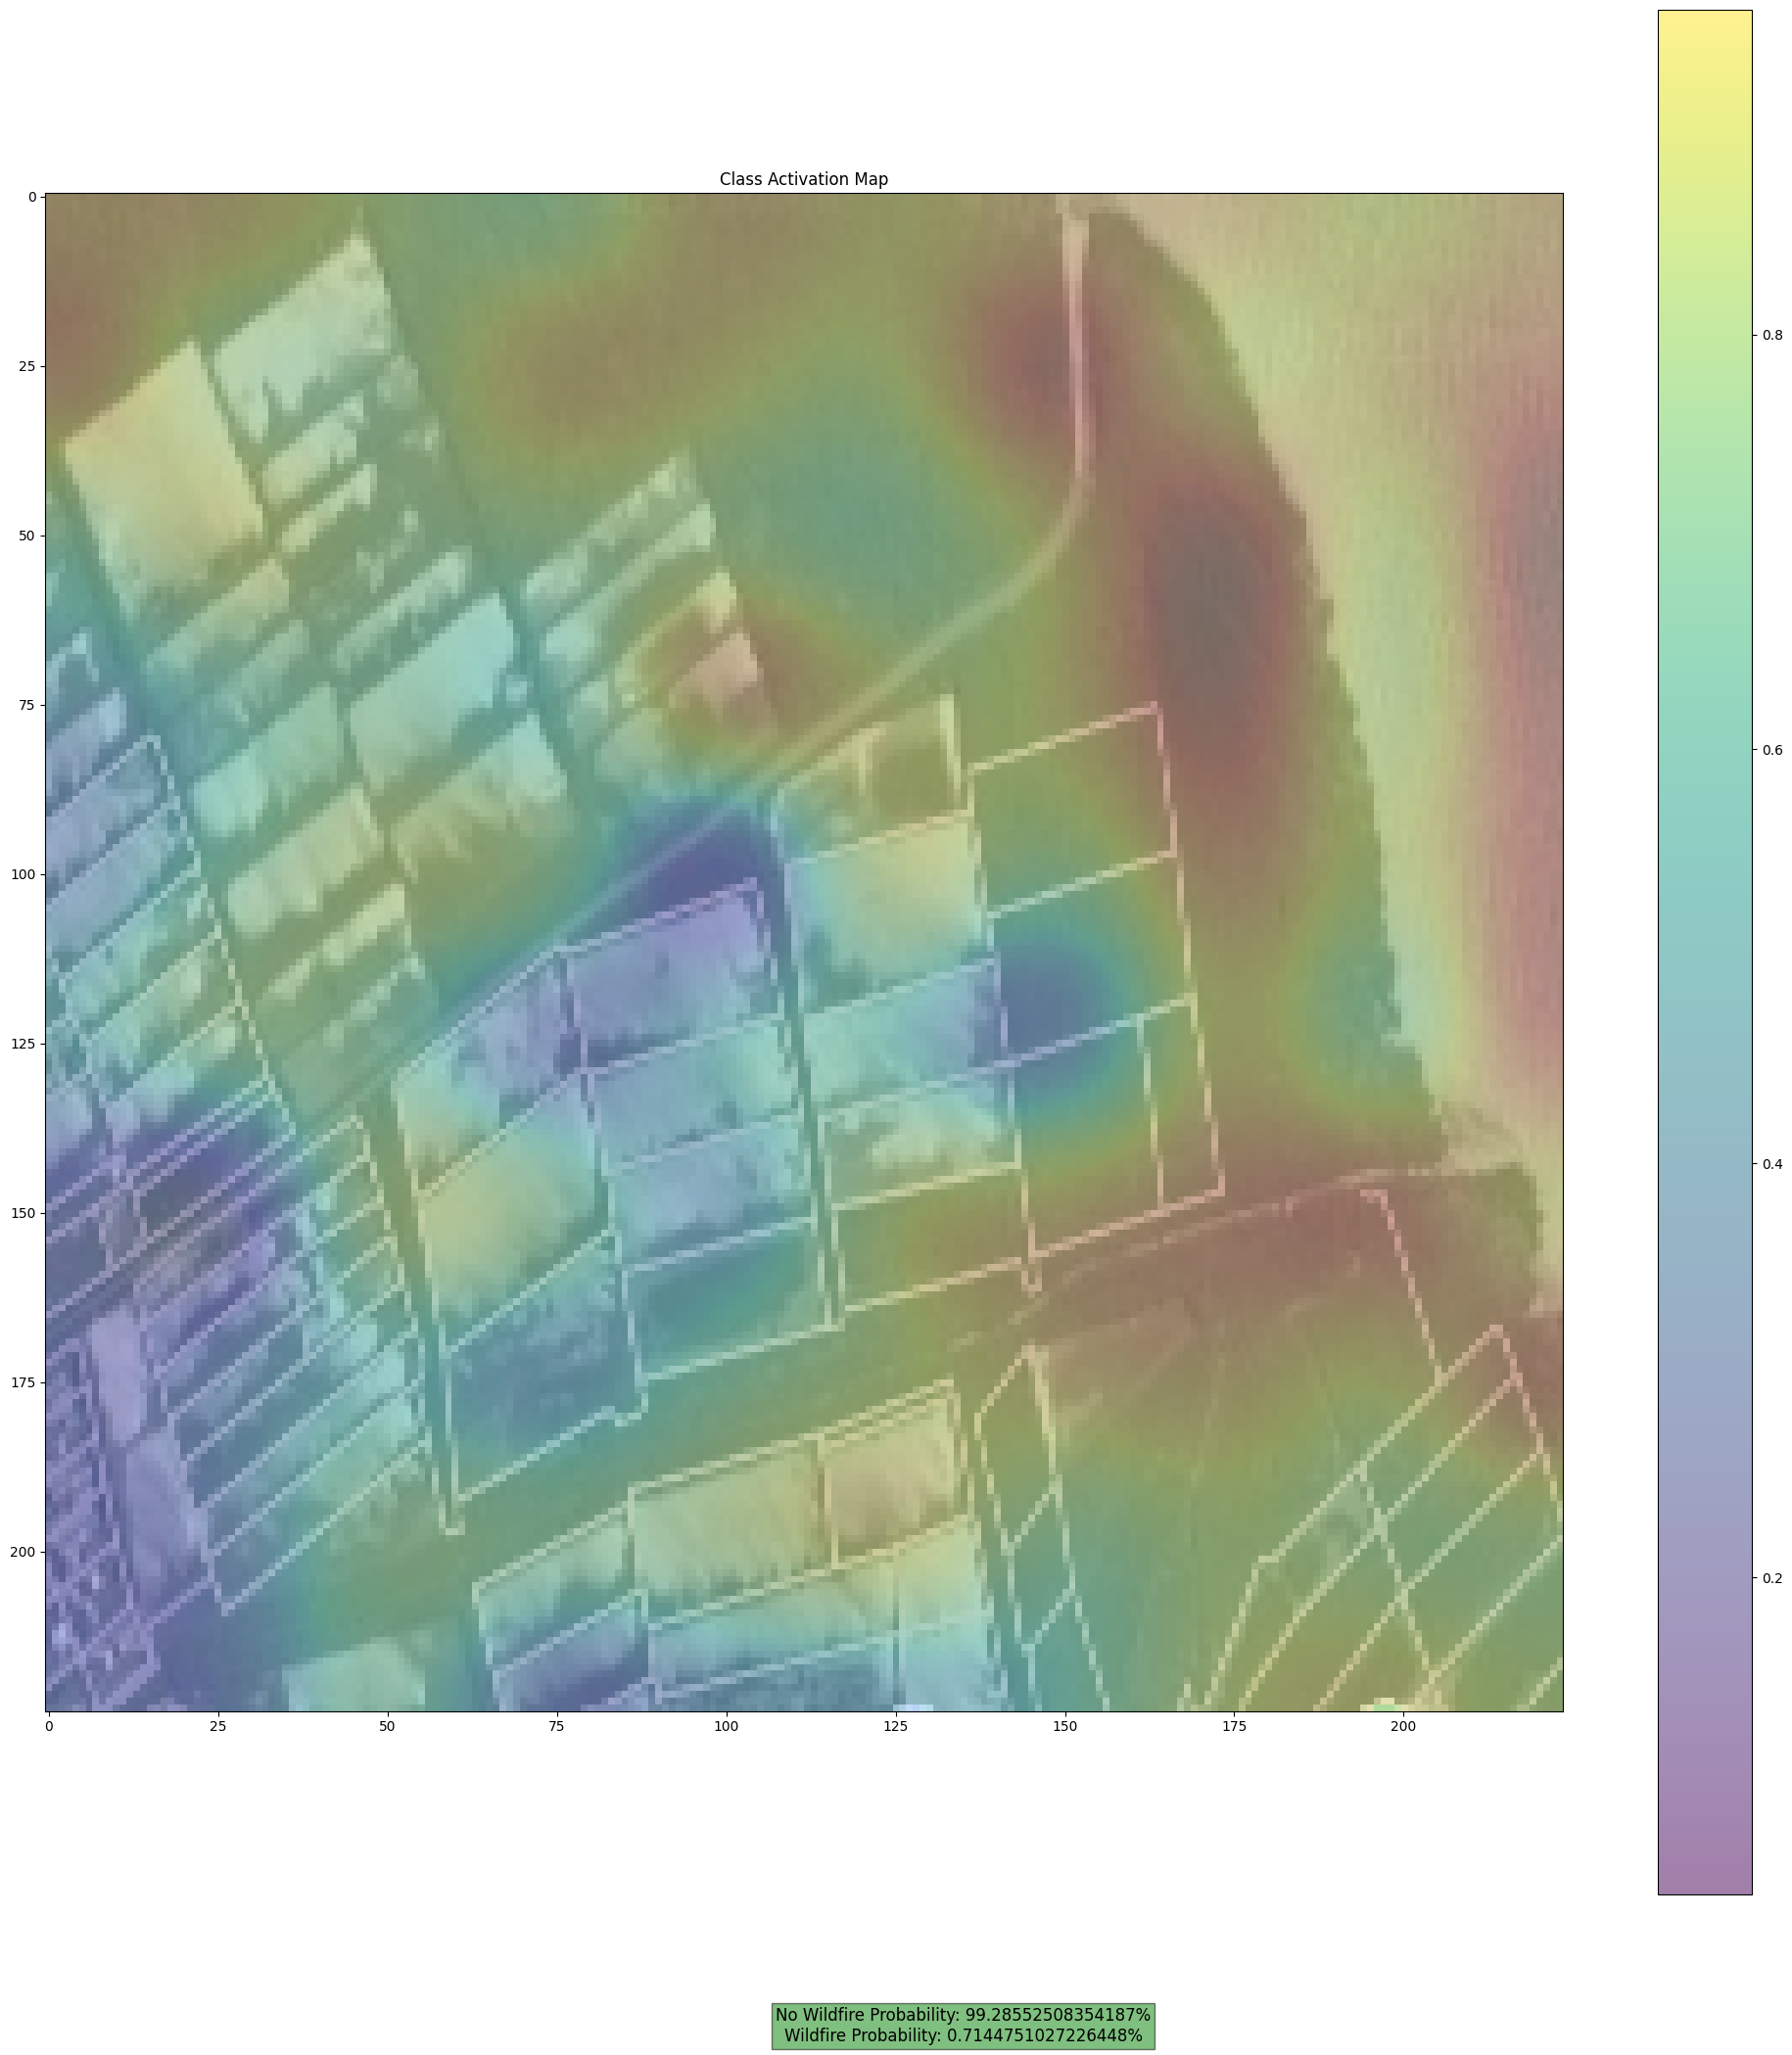

In [22]:
convert_and_classify(img)

In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as spnd

def compute_cam(features, class_weights, class_idx):
    """
    Compute a normalized CAM for the given class index.
    """
    # 1) Upsample the feature map to input image size
    feature_map = spnd.zoom(features, (im_size / features.shape[0],
                                       im_size / features.shape[1], 1), order=2)
    # 2) Weighted linear combination of the channels
    cam = np.dot(feature_map, class_weights[:, class_idx])
    # 3) Normalize to [0,1]
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    return cam

def overlay_cam_on_image(img, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlay the heatmap on the image.
    """
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(heatmap, alpha, np.uint8(255 * img), 1 - alpha, 0)
    return overlay, heatmap

def show_cam_insight(image_tensor, features, probs, class_weights, class_names):
    """
    Display:
      1) Original image
      2) CAM heatmap
      3) Overlay
      4) Probability bar chart
      5) Thresholded region bounding box
    """
    img = np.squeeze(image_tensor)
    # Predict class and compute CAM
    top_idx = np.argmax(probs)
    top_prob = probs[0, top_idx]
    
    cam = compute_cam(features[0], class_weights, top_idx)
    overlay, heatmap = overlay_cam_on_image(img, cam)

    # Find bounding box of the top-activated region
    thresh = 0.6
    mask = cam > thresh
    coords = np.column_stack(np.where(mask))
    if coords.size:
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
    else:
        y0 = x0 = y1 = x1 = 0

    # Plot everything
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(heatmap)
    axes[0, 1].set_title("Raw CAM Heatmap")
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(overlay)
    axes[0, 2].set_title(f"Overlay (Class = {class_names[top_idx]})")
    axes[0, 2].axis('off')

    # Draw bounding box on overlay
    if coords.size:
        axes[0, 2].add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0,
                                           edgecolor='white', lw=2, fill=False))
        axes[0, 2].text(x0, y0-10, 'Region of Interest',
                        color='white', fontsize=12, backgroundcolor='black')

    # Probability bar chart
    axes[1, 0].barh(class_names, probs[0])
    axes[1, 0].set_xlim(0,1)
    axes[1, 0].set_title("Class Probabilities")
    for i, v in enumerate(probs[0]):
        axes[1, 0].text(v + 0.01, i, f"{v*100:.1f}%", va='center')

    # Hide unused axes
    axes[1, 1].axis('off')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def convert_and_classify(image_path, class_names):
    import tensorflow as tf
    import cv2

    # 1) Load and preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (im_size, im_size)) / 255.0
    tensor = np.expand_dims(img_resized, axis=0)

    # 2) Get feature maps & predictions
    features, preds = cam_model.predict(tensor)

    # 3) Show the insightful CAM
    gap_w = cam_model.layers[-1].get_weights()[0] * -1
    show_cam_insight(tensor, features, preds, gap_w, class_names)


1/1 [==============================] - 0s 136ms/step


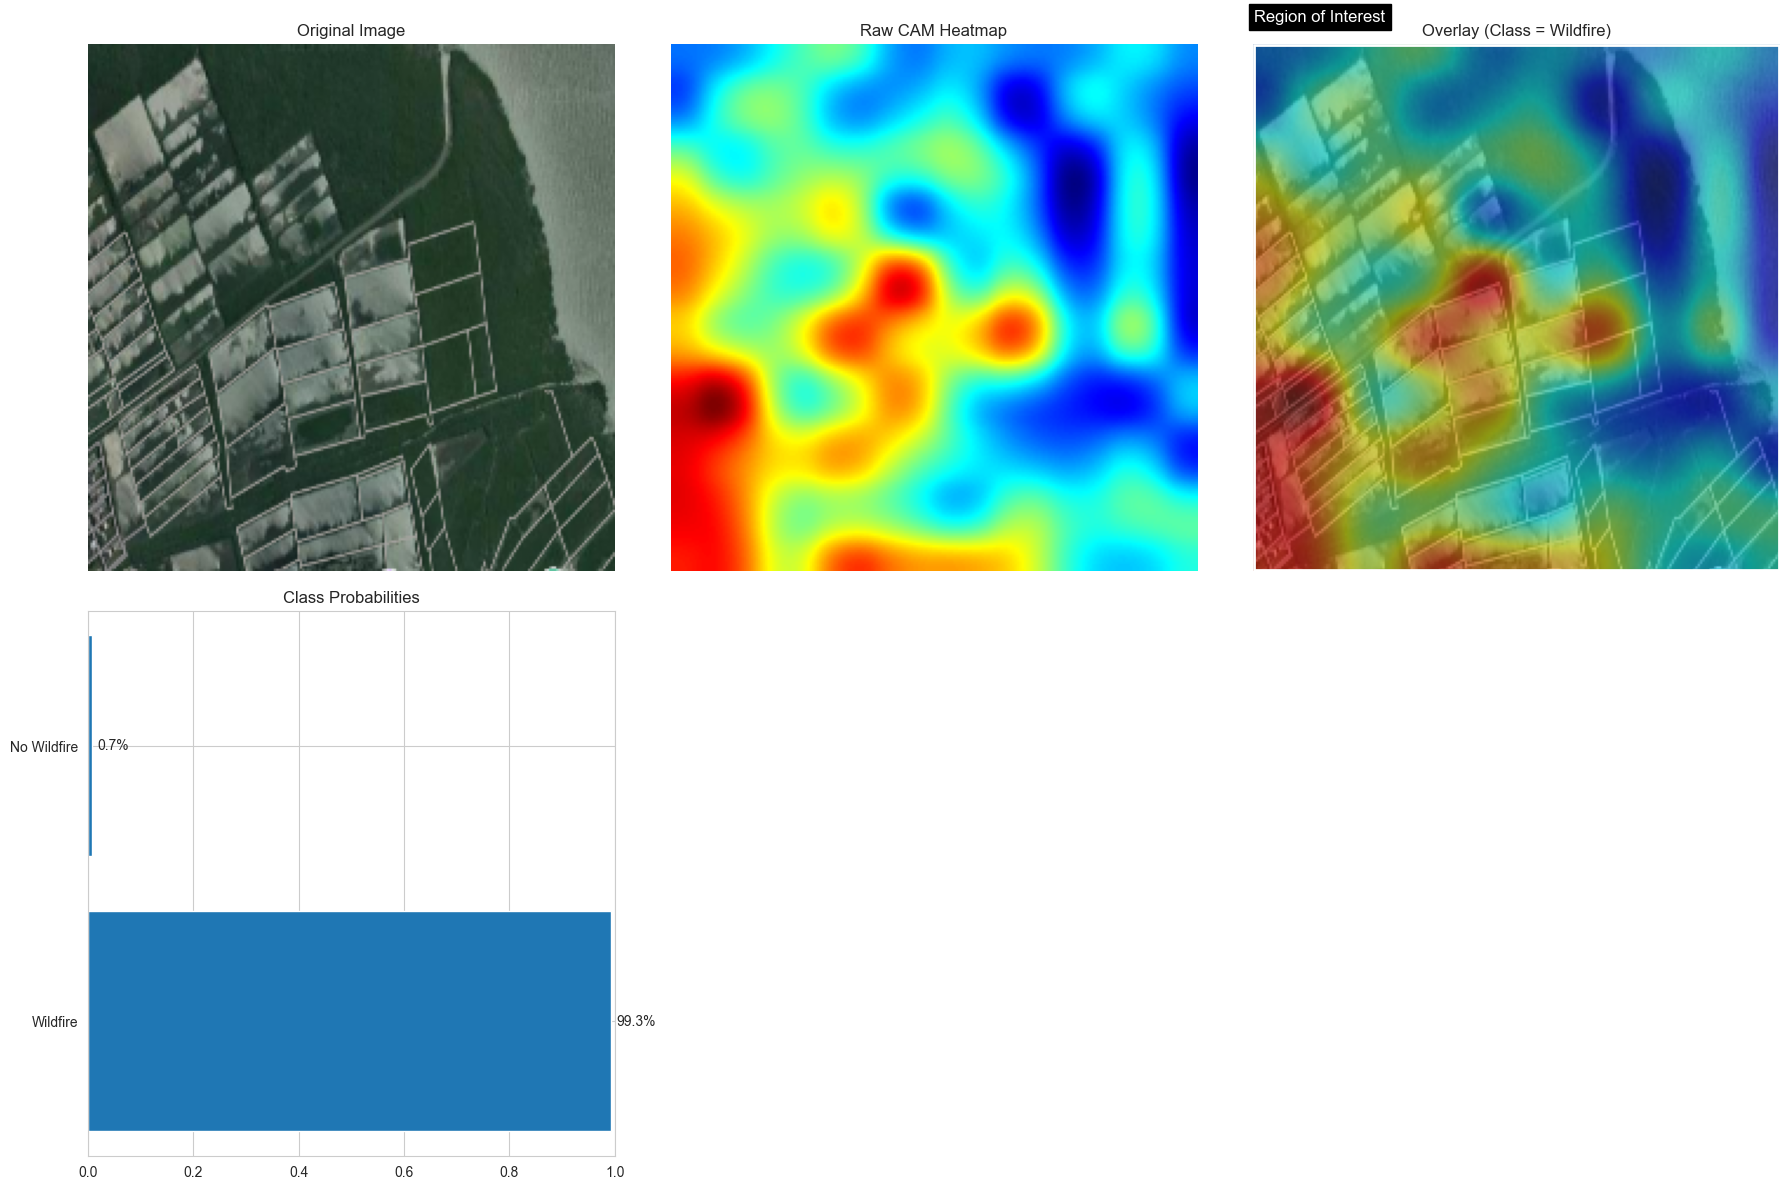

In [55]:
# after defining your two classes
class_names = ["Wildfire", "No Wildfire"]

# now call it with both arguments:
convert_and_classify(img, class_names)


In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as spnd
import tensorflow as tf

# Set your input image size (must match model's expected input)
im_size = 224  # example size, adjust as needed

# Load or reference your pre-trained CAM model here\#
# cam_model = tf.keras.models.load_model('path_to_your_cam_model')


def compute_cam(feature_map, class_weights, class_idx):
    """
    Compute a normalized Class Activation Map (CAM) for the given class index.
    """
    # Upsample feature map to input image size
    h, w, _ = feature_map.shape
    upsampled = spnd.zoom(feature_map,
                          (im_size / h,
                           im_size / w,
                           1), order=2)
    # Weighted linear combination
    cam = np.dot(upsampled, class_weights[:, class_idx])
    # Normalize to [0,1]
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    return cam


def overlay_cam_on_image(img, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Create an overlay of the CAM heatmap on the original image.
    """
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(heatmap, alpha, np.uint8(255 * img), 1 - alpha, 0)
    return overlay, heatmap


def show_cam_insight(image_tensor,
                     features,
                     probs,
                     class_weights,
                     class_names,
                     class_idx=None):
    """
    Display:
      1) Original image
      2) Raw CAM heatmap
      3) Overlay with optional bounding box
      4) Probability bar chart

    Args:
      image_tensor: preprocessed image tensor (1, H, W, C)
      features: activation features from the model
      probs: model prediction probabilities
      class_weights: weights from the final global pooling layer
      class_names: list of class label strings
      class_idx: optional index of class to visualize (defaults to predicted)
    """
    img = np.squeeze(image_tensor)

    # Determine which class to visualize
    if class_idx is None:
        class_idx = np.argmax(probs[0])
    top_prob = probs[0, class_idx]
    class_name = class_names[class_idx]

    # Compute CAM for the specified class
    cam = compute_cam(features[0], class_weights, class_idx)
    overlay, heatmap = overlay_cam_on_image(img, cam)

    # Find bounding box of regions above threshold
    thresh = 0.6
    mask = cam > thresh
    coords = np.column_stack(np.where(mask))
    if coords.size:
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
    else:
        y0 = x0 = y1 = x1 = None

    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original
    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # Raw CAM
    axes[0, 1].imshow(cam, cmap='jet')
    axes[0, 1].set_title(f"CAM Heatmap ({class_name})")
    axes[0, 1].axis('off')

    # Overlay
    axes[0, 2].imshow(overlay)
    axes[0, 2].set_title(f"Overlay (Prob = {top_prob*100:.1f}% )")
    axes[0, 2].axis('off')
    if coords.size:
        axes[0, 2].add_patch(
            plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                          edgecolor='white', lw=2, fill=False)
        )
        axes[0, 2].text(x0, y0 - 10, 'ROI',
                        color='white', fontsize=12,
                        backgroundcolor='black')

    # Probability bar chart
    axes[1, 0].barh(class_names, probs[0])
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].set_title("Class Probabilities")
    for i, v in enumerate(probs[0]):
        axes[1, 0].text(v + 0.01, i, f"{v*100:.1f}%", va='center')

    # Hide unused subplots
    axes[1, 1].axis('off')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()


def convert_and_classify(image_path,
                         class_names=["No Wildfire", "Wildfire"],
                         class_idx=None):
    """
    Load an image, run the CAM model, and display an insightful CAM.
    Args:
      image_path: path to the input image file
      class_names: list of class labels
      class_idx: index of class to visualize (defaults to predicted)
    """
    # Load & preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (im_size, im_size)) / 255.0
    tensor = np.expand_dims(img_resized, axis=0)

    # Forward pass
    features, preds = cam_model.predict(tensor)

    # Get final-layer (GAP) weights
    gap_w = cam_model.layers[-1].get_weights()[0]

    # Show CAM
    show_cam_insight(tensor, features, preds, gap_w, class_names, class_idx)


# Example usage:
# class_labels = ["No Wildfire", "Wildfire"]
# convert_and_classify('path/to/image.jpg', class_labels, class_idx=1)


1/1 [==============================] - 0s 88ms/step


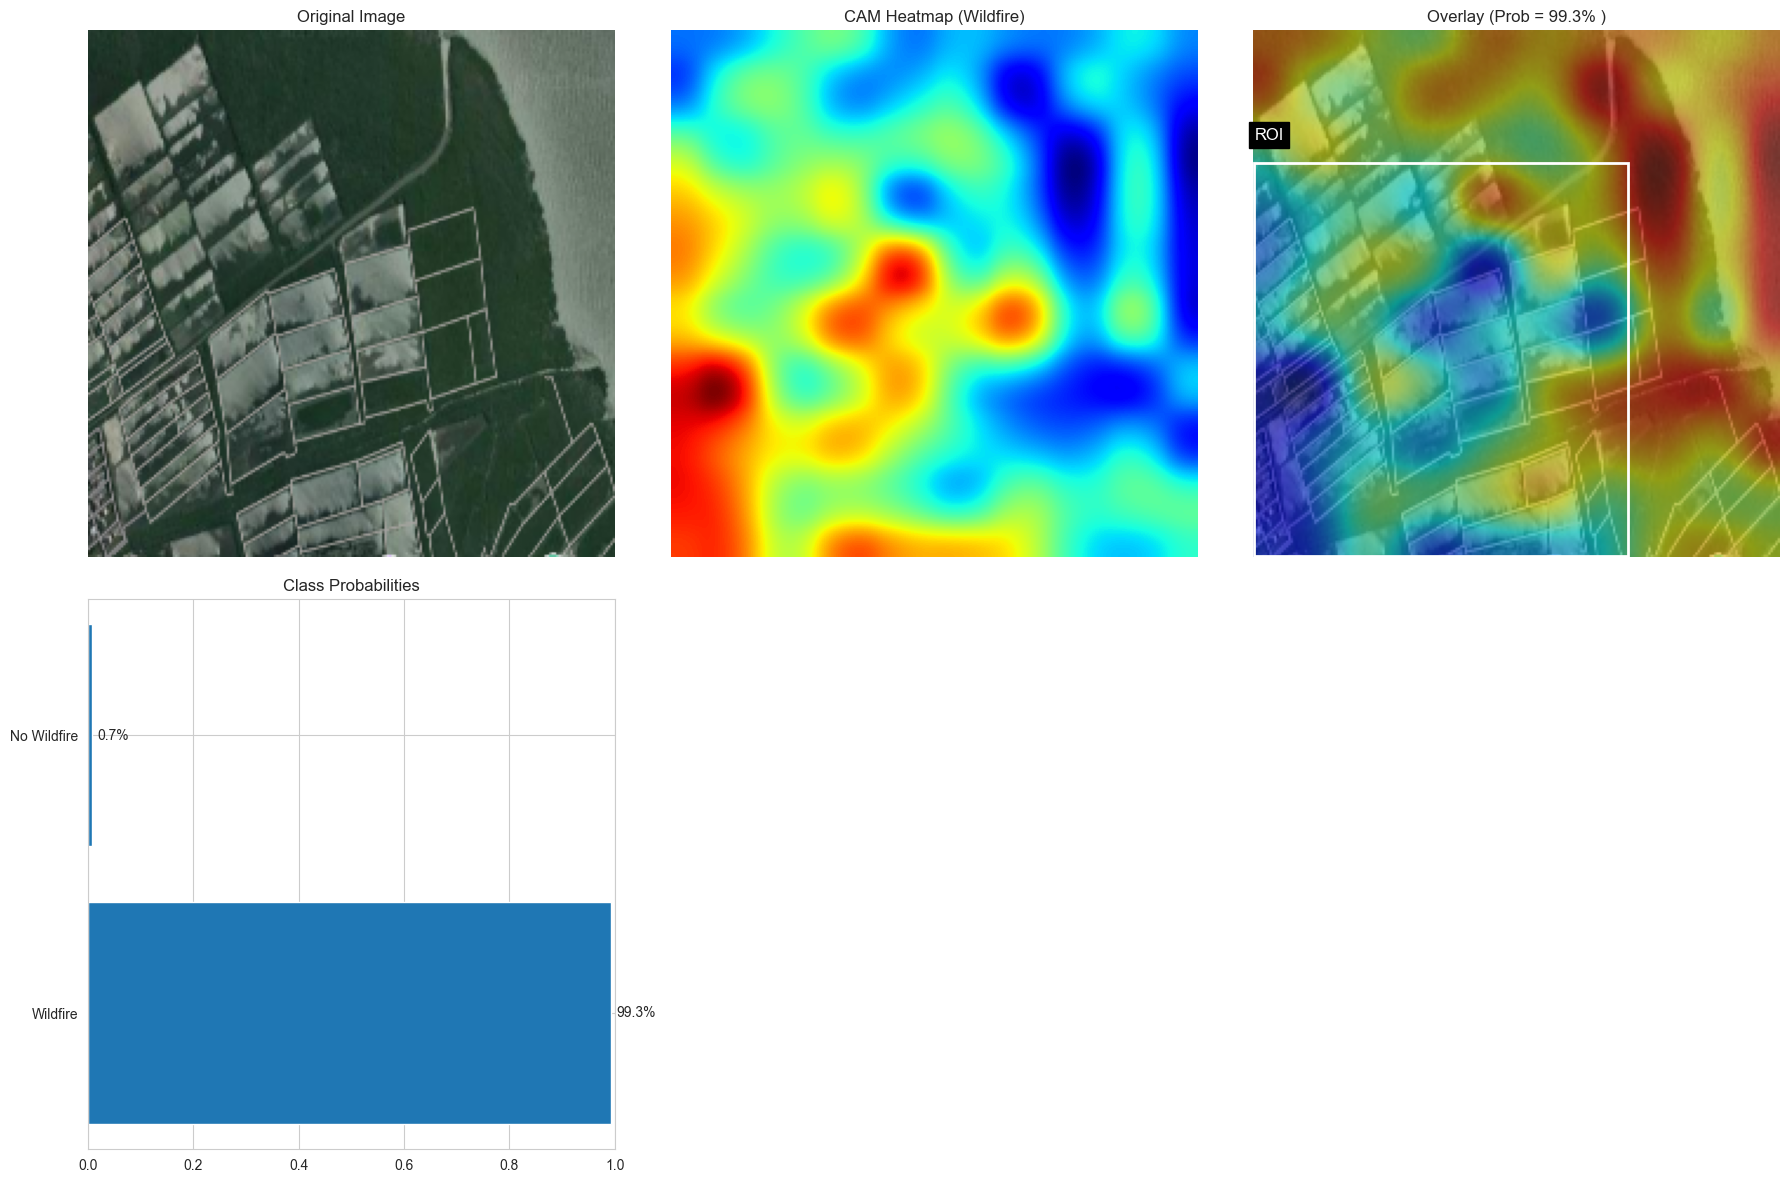

In [60]:
# visualize the wildfire‐specific CAM
convert_and_classify(img, class_names, class_idx=0)
